## 📦 1. Import Libraries

Import required libraries for deep learning, signal processing, and visualization.

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy import signal
from pathlib import Path
import glob
import json
import csv
from tqdm import tqdm
import pandas as pd

print("✅ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")

# Configure device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("🎮 NVIDIA GPU detected (CUDA)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 Apple Silicon GPU detected (MPS)")
else:
    device = torch.device("cpu")
    print("💻 Using CPU")

print(f"🖥️  Computing device: {device}")

✅ Libraries imported successfully
PyTorch version: 2.9.1
🍎 Apple Silicon GPU detected (MPS)
🖥️  Computing device: mps


## ⚙️ 2. Configuration

Define analysis parameters and directory paths.

In [3]:
# ============================================
# SPECTRAL ANALYSIS CONFIGURATION
# ============================================

# Upsampling factors to analyze
INPUT_SIZES = [1000, 500, 250, 150]
OUTPUT_SIZE = 5000
UPSAMPLE_FACTORS = [OUTPUT_SIZE // size for size in INPUT_SIZES]  # [5, 10, 20, 33]

# Sampling rate (from CoSiBD dataset)
# Domain: [0, 4π], 5000 samples → fs = 5000/(4π) ≈ 398 Hz
SAMPLING_RATE = 5000 / (4 * np.pi)  # ~398 Hz

# Spectral analysis parameters
FRAME_LENGTH_MS = 25  # Window length in milliseconds
OVERLAP_MS = 15       # Overlap between windows
NFFT = 256            # FFT points for spectrogram
NOVERLAP = 128        # Overlap samples for spectrogram

# Directories
DATA_DIR = Path("./data_multifactor")
MODELS_DIR = Path("./models_multifactor")
RESULTS_DIR = Path("./results_spectral")
RESULTS_DIR.mkdir(exist_ok=True)

# Output subdirectories
(RESULTS_DIR / "spectrograms").mkdir(exist_ok=True)
(RESULTS_DIR / "metrics").mkdir(exist_ok=True)
(RESULTS_DIR / "figures").mkdir(exist_ok=True)

print("="*60)
print("SPECTRAL ANALYSIS CONFIGURATION")
print("="*60)
print(f"📊 Input sizes: {INPUT_SIZES}")
print(f"📊 Output size: {OUTPUT_SIZE}")
print(f"⚡ Upsampling factors: {UPSAMPLE_FACTORS}")
print(f"🎵 Sampling rate: {SAMPLING_RATE:.2f} Hz")
print(f"🔊 Frame length: {FRAME_LENGTH_MS} ms")
print(f"🔊 Overlap: {OVERLAP_MS} ms")
print(f"📁 Results directory: {RESULTS_DIR}")
print("="*60)

SPECTRAL ANALYSIS CONFIGURATION
📊 Input sizes: [1000, 500, 250, 150]
📊 Output size: 5000
⚡ Upsampling factors: [5, 10, 20, 33]
🎵 Sampling rate: 397.89 Hz
🔊 Frame length: 25 ms
🔊 Overlap: 15 ms
📁 Results directory: results_spectral


## 🏗️ 3. Model Architecture Definition

Define the TimeSeriesSRNet architecture (same as training notebook).

In [4]:
class TimeSeriesSRNet(nn.Module):
    """
    Convolutional Neural Network for Super-Resolution of Time Series.
    
    Encoder-Decoder Architecture:
    - Encoder: Extracts multi-scale features
    - Upsampler: Increases resolution and refines the signal
    
    Args:
        input_size (int): Input signal length
        output_size (int): Desired output signal length
        hidden_channels (list): Channels in each encoder layer
    """
    def __init__(self, input_size=150, output_size=5000, hidden_channels=[64, 128, 256]):
        super(TimeSeriesSRNet, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        
        # ==================== ENCODER ====================
        self.encoder = nn.Sequential(
            nn.Conv1d(1, hidden_channels[0], kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(hidden_channels[0]),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(hidden_channels[0], hidden_channels[1], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[1]),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(hidden_channels[1], hidden_channels[2], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[2]),
            nn.ReLU(inplace=True),
        )
        
        # ==================== UPSAMPLER ====================
        self.upsample = nn.Sequential(
            nn.Upsample(size=output_size, mode='linear', align_corners=True),
            
            nn.Conv1d(hidden_channels[2], hidden_channels[1], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[1]),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(hidden_channels[1], hidden_channels[0], kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(hidden_channels[0]),
            nn.ReLU(inplace=True),
            
            nn.Conv1d(hidden_channels[0], 1, kernel_size=9, stride=1, padding=4)
        )
    
    def forward(self, x):
        features = self.encoder(x)
        output = self.upsample(features)
        return output

print("✅ TimeSeriesSRNet architecture defined")

✅ TimeSeriesSRNet architecture defined


## 📊 4. Spectral Metrics Functions

Define functions to compute Log Spectral Distance and Spectral Correlation.

In [5]:
def compute_log_spectral_distance(clean_signal, noisy_signal, fs, frame_length_ms=25, overlap_ms=15):
    """
    Compute Log Spectral Distance (LSD) between two signals.
    
    LSD measures the difference in spectral content on a logarithmic scale,
    similar to human perception of sound.
    
    Args:
        clean_signal: Reference signal (ground truth)
        noisy_signal: Reconstructed signal
        fs: Sampling frequency
        frame_length_ms: Window length in milliseconds
        overlap_ms: Overlap between windows in milliseconds
    
    Returns:
        float: Average LSD across all frames (lower is better)
    """
    # Ensure signals have same length
    min_len = min(len(clean_signal), len(noisy_signal))
    clean_signal = clean_signal[:min_len]
    noisy_signal = noisy_signal[:min_len]
    
    # Normalize signals (L2 norm)
    clean_signal = clean_signal / np.sqrt(np.sum(clean_signal**2) + 1e-10)
    noisy_signal = noisy_signal / np.sqrt(np.sum(noisy_signal**2) + 1e-10)
    
    # Convert ms to samples
    frame_length_samples = int(fs * frame_length_ms / 1000)
    overlap_samples = int(fs * overlap_ms / 1000)
    nperseg = frame_length_samples
    noverlap = overlap_samples
    
    # Compute spectrograms
    freqs, t_clean, Sxx_clean = spectrogram(clean_signal, fs, nperseg=nperseg, noverlap=noverlap)
    freqs, t_noisy, Sxx_noisy = spectrogram(noisy_signal, fs, nperseg=nperseg, noverlap=noverlap)
    
    # Convert to log power spectra (add epsilon to avoid log(0))
    log_Sxx_clean = np.log(Sxx_clean + np.finfo(float).eps)
    log_Sxx_noisy = np.log(Sxx_noisy + np.finfo(float).eps)
    
    # Calculate LSD per frame
    lsd_per_frame = np.sqrt(np.mean((log_Sxx_clean - log_Sxx_noisy)**2, axis=0))
    
    # Average LSD over all frames
    average_lsd = np.mean(lsd_per_frame)
    
    return average_lsd


def compute_spectral_correlation(signal1, signal2, fs, nperseg=256):
    """
    Compute Spectral Correlation (SCORR) between two signals.
    
    SCORR measures the correlation between power spectral densities,
    providing a similarity metric in the frequency domain.
    
    Args:
        signal1: First signal (reference)
        signal2: Second signal (reconstructed)
        fs: Sampling frequency
        nperseg: Length of each segment for PSD estimation
    
    Returns:
        float: Spectral correlation [0, 1] (higher is better, 1 = identical)
    """
    # Ensure signals have same length
    min_len = min(len(signal1), len(signal2))
    signal1 = signal1[:min_len]
    signal2 = signal2[:min_len]
    
    # Compute Power Spectral Density using Welch's method
    freqs1, psd1 = signal.welch(signal1, fs, nperseg=nperseg)
    freqs2, psd2 = signal.welch(signal2, fs, nperseg=nperseg)
    
    # Compute correlation coefficient
    correlation = np.corrcoef(psd1, psd2)[0, 1]
    
    return correlation


print("✅ Spectral metrics functions defined")

✅ Spectral metrics functions defined


## 🎨 5. Visualization Functions

Define functions to plot spectrograms and comparative figures.

In [6]:
def plot_single_spectrogram_comparison(original, reconstructed, fs, factor, 
                                      save_path=None, NFFT=256, noverlap=128):
    """
    Plot side-by-side comparison of original and reconstructed signal spectrograms.
    
    Args:
        original: Original high-resolution signal
        reconstructed: Reconstructed signal from CNN
        fs: Sampling frequency
        factor: Upsampling factor (for title)
        save_path: Optional path to save figure
        NFFT: FFT points
        noverlap: Overlap samples
    """
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    
    # Time vectors
    t_orig = np.arange(len(original)) / fs
    t_recon = np.arange(len(reconstructed)) / fs
    
    # First row: time-domain signals
    axs[0, 0].plot(t_orig, original, linewidth=0.8)
    axs[0, 0].set_title(f"Original Signal ({factor}x)", fontsize=12, fontweight='bold')
    axs[0, 0].set_xlabel("Time (s)")
    axs[0, 0].set_ylabel("Amplitude")
    axs[0, 0].grid(True, alpha=0.3)
    
    axs[0, 1].plot(t_recon, reconstructed, color='orange', linewidth=0.8)
    axs[0, 1].set_title(f"Reconstructed Signal ({factor}x)", fontsize=12, fontweight='bold')
    axs[0, 1].set_xlabel("Time (s)")
    axs[0, 1].set_ylabel("Amplitude")
    axs[0, 1].grid(True, alpha=0.3)
    
    # Second row: spectrograms
    spec_kwargs = dict(cmap='rainbow')
    
    Pxx1, freqs1, bins1, im1 = axs[1, 0].specgram(original, Fs=fs, NFFT=NFFT, 
                                                    noverlap=noverlap, **spec_kwargs)
    axs[1, 0].set_title("Original Spectrogram", fontsize=12, fontweight='bold')
    axs[1, 0].set_xlabel("Time (s)")
    axs[1, 0].set_ylabel("Frequency (Hz)")
    axs[1, 0].set_ylim(0, fs/2)
    
    Pxx2, freqs2, bins2, im2 = axs[1, 1].specgram(reconstructed, Fs=fs, NFFT=NFFT, 
                                                    noverlap=noverlap, **spec_kwargs)
    axs[1, 1].set_title("Reconstructed Spectrogram", fontsize=12, fontweight='bold')
    axs[1, 1].set_xlabel("Time (s)")
    axs[1, 1].set_ylabel("Frequency (Hz)")
    axs[1, 1].set_ylim(0, fs/2)
    
    # Shared color scale
    vmin = min(im1.get_array().min(), im2.get_array().min())
    vmax = max(im1.get_array().max(), im2.get_array().max())
    im1.set_clim(vmin, vmax)
    im2.set_clim(vmin, vmax)
    
    # Single colorbar
    cbar = fig.colorbar(im1, ax=axs[1, :], orientation="horizontal", 
                       fraction=0.05, pad=0.1)
    cbar.set_label("Intensity (dB)", fontsize=11)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"   💾 Saved: {save_path}")
    
    plt.show()


def plot_multifactor_grid(signals_dict, fs, save_path=None, NFFT=256, noverlap=128):
    """
    Plot 4x3 grid comparing all upsampling factors.
    
    Rows: 5x, 10x, 20x, 33x
    Columns: Original, Reconstructed, Difference
    
    Args:
        signals_dict: Dict with keys like '5x', '10x' containing (original, reconstructed) tuples
        fs: Sampling frequency
        save_path: Optional path to save figure
    """
    fig, axs = plt.subplots(4, 3, figsize=(18, 16))
    
    factors_order = ['5x', '10x', '20x', '33x']
    
    for row, factor in enumerate(factors_order):
        if factor not in signals_dict:
            continue
            
        original, reconstructed = signals_dict[factor]
        difference = original - reconstructed
        
        # Column 0: Original spectrogram
        Pxx1, _, _, im1 = axs[row, 0].specgram(original, Fs=fs, NFFT=NFFT, 
                                                noverlap=noverlap, cmap='rainbow')
        axs[row, 0].set_ylabel(f"{factor}\nFrequency (Hz)", fontsize=10)
        axs[row, 0].set_ylim(0, fs/2)
        if row == 0:
            axs[row, 0].set_title("Original", fontsize=12, fontweight='bold')
        if row == 3:
            axs[row, 0].set_xlabel("Time (s)")
        
        # Column 1: Reconstructed spectrogram
        Pxx2, _, _, im2 = axs[row, 1].specgram(reconstructed, Fs=fs, NFFT=NFFT, 
                                                noverlap=noverlap, cmap='rainbow')
        axs[row, 1].set_ylim(0, fs/2)
        axs[row, 1].set_yticklabels([])
        if row == 0:
            axs[row, 1].set_title("Reconstructed", fontsize=12, fontweight='bold')
        if row == 3:
            axs[row, 1].set_xlabel("Time (s)")
        
        # Column 2: Difference spectrogram
        Pxx3, _, _, im3 = axs[row, 2].specgram(difference, Fs=fs, NFFT=NFFT, 
                                                noverlap=noverlap, cmap='seismic')
        axs[row, 2].set_ylim(0, fs/2)
        axs[row, 2].set_yticklabels([])
        if row == 0:
            axs[row, 2].set_title("Difference (Error)", fontsize=12, fontweight='bold')
        if row == 3:
            axs[row, 2].set_xlabel("Time (s)")
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        print(f"💾 Multi-factor grid saved: {save_path}")
    
    plt.show()


print("✅ Visualization functions defined")

✅ Visualization functions defined


## 📂 6. Load Data and Models

Load validation signals and trained models for all factors.

In [8]:
def load_validation_signals(input_size):
    """Load validation signals for a specific input size."""
    factor_dir = DATA_DIR / f"{input_size}_samples" / "validation"
    low_dir = factor_dir / "low_res"
    high_dir = factor_dir / "high_res"
    
    low_files = sorted(glob.glob(str(low_dir / "*.txt")))
    high_files = sorted(glob.glob(str(high_dir / "*.txt")))
    
    assert len(low_files) == len(high_files), "Mismatch in file counts"
    
    low_signals = []
    high_signals = []
    
    for low_file, high_file in zip(low_files, high_files):
        low_signals.append(np.loadtxt(low_file, dtype=np.float32))
        high_signals.append(np.loadtxt(high_file, dtype=np.float32))
    
    return np.array(low_signals), np.array(high_signals)


# Dictionary to store all data
validation_data = {}
models = {}

print("\n" + "="*60)
print("📂 LOADING VALIDATION DATA AND MODELS")
print("="*60)

for input_size, factor in zip(INPUT_SIZES, UPSAMPLE_FACTORS):
    print(f"\n🔄 Loading {factor}x upsampling ({input_size} → {OUTPUT_SIZE})...")
    
    # Load validation signals
    low_signals, high_signals = load_validation_signals(input_size)
    validation_data[factor] = {
        'low': low_signals,
        'high': high_signals,
        'input_size': input_size
    }
    print(f"   ✅ Loaded {len(low_signals)} validation signal pairs")
    
    # Load trained model
    model_path = MODELS_DIR / f"best_model_upsample{factor}x.pth"
    
    if model_path.exists():
        model = TimeSeriesSRNet(input_size=input_size, output_size=OUTPUT_SIZE)
        
        # Load checkpoint (contains metadata + model weights)
        checkpoint = torch.load(model_path, map_location=device)
        
        # Extract model weights from checkpoint
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            # Fallback: try loading directly (in case it's just weights)
            model.load_state_dict(checkpoint)
        
        model.to(device)
        model.eval()
        models[factor] = model
        print(f"   ✅ Model loaded: {model_path.name}")
    else:
        print(f"   ⚠️  Model not found: {model_path}")
        models[factor] = None

print("\n" + "="*60)
print(f"✅ Loaded {len(models)} models and {len(validation_data)} validation datasets")
print("="*60)


📂 LOADING VALIDATION DATA AND MODELS

🔄 Loading 5x upsampling (1000 → 5000)...
   ✅ Loaded 500 validation signal pairs
   ✅ Model loaded: best_model_upsample5x.pth

🔄 Loading 10x upsampling (500 → 5000)...
   ✅ Loaded 500 validation signal pairs
   ✅ Model loaded: best_model_upsample5x.pth

🔄 Loading 10x upsampling (500 → 5000)...
   ✅ Loaded 500 validation signal pairs
   ✅ Model loaded: best_model_upsample10x.pth

🔄 Loading 20x upsampling (250 → 5000)...
   ✅ Loaded 500 validation signal pairs
   ✅ Model loaded: best_model_upsample10x.pth

🔄 Loading 20x upsampling (250 → 5000)...
   ✅ Loaded 500 validation signal pairs
   ✅ Model loaded: best_model_upsample20x.pth

🔄 Loading 33x upsampling (150 → 5000)...
   ✅ Loaded 500 validation signal pairs
   ✅ Model loaded: best_model_upsample20x.pth

🔄 Loading 33x upsampling (150 → 5000)...
   ✅ Loaded 500 validation signal pairs
   ✅ Model loaded: best_model_upsample33x.pth

✅ Loaded 4 models and 4 validation datasets
   ✅ Loaded 500 validat

## 🔬 7. Generate Predictions

Generate reconstructed signals for all validation data.

In [9]:
# Dictionary to store predictions
predictions = {}

print("\n" + "="*60)
print("🚀 GENERATING PREDICTIONS")
print("="*60)

for factor in UPSAMPLE_FACTORS:
    if models[factor] is None:
        print(f"⚠️  Skipping {factor}x (model not loaded)")
        continue
    
    print(f"\n🔄 Generating predictions for {factor}x upsampling...")
    
    low_signals = validation_data[factor]['low']
    model = models[factor]
    
    # Convert to tensor
    low_tensor = torch.tensor(low_signals, dtype=torch.float32).unsqueeze(1).to(device)
    
    # Generate predictions
    with torch.no_grad():
        reconstructed = model(low_tensor).squeeze(1).cpu().numpy()
    
    predictions[factor] = reconstructed
    print(f"   ✅ Generated {len(reconstructed)} predictions")

print("\n" + "="*60)
print(f"✅ Predictions generated for {len(predictions)} factors")
print("="*60)


🚀 GENERATING PREDICTIONS

🔄 Generating predictions for 5x upsampling...
   ✅ Generated 500 predictions

🔄 Generating predictions for 10x upsampling...
   ✅ Generated 500 predictions

🔄 Generating predictions for 10x upsampling...
   ✅ Generated 500 predictions

🔄 Generating predictions for 20x upsampling...
   ✅ Generated 500 predictions

🔄 Generating predictions for 20x upsampling...
   ✅ Generated 500 predictions

🔄 Generating predictions for 33x upsampling...
   ✅ Generated 500 predictions

🔄 Generating predictions for 33x upsampling...
   ✅ Generated 500 predictions

✅ Predictions generated for 4 factors
   ✅ Generated 500 predictions

✅ Predictions generated for 4 factors


## 📈 8. Compute Spectral Metrics

Calculate LSD and SCORR for all signals.

In [10]:
# Storage for all metrics
all_metrics = []

print("\n" + "="*60)
print("📊 COMPUTING SPECTRAL METRICS")
print("="*60)

for factor in UPSAMPLE_FACTORS:
    if factor not in predictions:
        continue
    
    print(f"\n🔬 Analyzing {factor}x upsampling...")
    
    high_signals = validation_data[factor]['high']
    reconstructed_signals = predictions[factor]
    
    lsd_values = []
    scorr_values = []
    
    # Compute metrics for each signal
    for i, (original, reconstructed) in enumerate(tqdm(
        zip(high_signals, reconstructed_signals), 
        total=len(high_signals),
        desc=f"  {factor}x metrics"
    )):
        # Compute LSD
        lsd = compute_log_spectral_distance(
            original, reconstructed, 
            SAMPLING_RATE, 
            FRAME_LENGTH_MS, 
            OVERLAP_MS
        )
        lsd_values.append(lsd)
        
        # Compute SCORR
        scorr = compute_spectral_correlation(
            original, reconstructed,
            SAMPLING_RATE,
            nperseg=NFFT
        )
        scorr_values.append(scorr)
        
        # Store individual result
        all_metrics.append({
            'factor': f"{factor}x",
            'signal_idx': i,
            'lsd': lsd,
            'scorr': scorr
        })
    
    # Print summary statistics
    lsd_mean = np.mean(lsd_values)
    lsd_std = np.std(lsd_values)
    scorr_mean = np.mean(scorr_values)
    scorr_std = np.std(scorr_values)
    
    print(f"\n   📊 {factor}x Results:")
    print(f"      LSD:   {lsd_mean:.4f} ± {lsd_std:.4f}")
    print(f"      SCORR: {scorr_mean:.4f} ± {scorr_std:.4f}")

print("\n" + "="*60)
print(f"✅ Computed metrics for {len(all_metrics)} signals")
print("="*60)


📊 COMPUTING SPECTRAL METRICS

🔬 Analyzing 5x upsampling...


  5x metrics: 100%|██████████| 500/500 [00:00<00:00, 680.27it/s]



   📊 5x Results:
      LSD:   0.5051 ± 0.6292
      SCORR: 0.9848 ± 0.0970

🔬 Analyzing 10x upsampling...


  10x metrics: 100%|██████████| 500/500 [00:00<00:00, 683.38it/s]



   📊 10x Results:
      LSD:   0.6384 ± 0.6317
      SCORR: 0.9845 ± 0.0960

🔬 Analyzing 20x upsampling...


  20x metrics: 100%|██████████| 500/500 [00:00<00:00, 681.47it/s]



   📊 20x Results:
      LSD:   0.9522 ± 0.6700
      SCORR: 0.9817 ± 0.1014

🔬 Analyzing 33x upsampling...


  33x metrics: 100%|██████████| 500/500 [00:00<00:00, 677.44it/s]


   📊 33x Results:
      LSD:   1.2106 ± 0.6659
      SCORR: 0.9776 ± 0.1072

✅ Computed metrics for 2000 signals


## 💾 9. Export Results to CSV and JSON

Save detailed metrics to files.

In [11]:
# ==================== SAVE CSV (PER-SIGNAL METRICS) ====================
csv_path = RESULTS_DIR / "metrics" / "spectral_metrics_per_signal.csv"

with open(csv_path, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['factor', 'signal_idx', 'lsd', 'scorr'])
    writer.writeheader()
    writer.writerows(all_metrics)

print(f"✅ CSV saved: {csv_path}")

# ==================== SAVE JSON (SUMMARY STATISTICS) ====================
summary_stats = {}

for factor in UPSAMPLE_FACTORS:
    factor_metrics = [m for m in all_metrics if m['factor'] == f"{factor}x"]
    
    if len(factor_metrics) > 0:
        lsd_vals = [m['lsd'] for m in factor_metrics]
        scorr_vals = [m['scorr'] for m in factor_metrics]
        
        summary_stats[f"{factor}x"] = {
            'num_signals': len(factor_metrics),
            'lsd': {
                'mean': float(np.mean(lsd_vals)),
                'std': float(np.std(lsd_vals)),
                'min': float(np.min(lsd_vals)),
                'max': float(np.max(lsd_vals)),
                'median': float(np.median(lsd_vals))
            },
            'scorr': {
                'mean': float(np.mean(scorr_vals)),
                'std': float(np.std(scorr_vals)),
                'min': float(np.min(scorr_vals)),
                'max': float(np.max(scorr_vals)),
                'median': float(np.median(scorr_vals))
            }
        }

json_path = RESULTS_DIR / "metrics" / "spectral_metrics_summary.json"

with open(json_path, 'w') as f:
    json.dump(summary_stats, f, indent=2)

print(f"✅ JSON summary saved: {json_path}")

# Display summary
print("\n" + "="*60)
print("📊 SPECTRAL METRICS SUMMARY")
print("="*60)
for factor_name, stats in summary_stats.items():
    print(f"\n{factor_name}:")
    print(f"  LSD:   {stats['lsd']['mean']:.4f} ± {stats['lsd']['std']:.4f}")
    print(f"  SCORR: {stats['scorr']['mean']:.4f} ± {stats['scorr']['std']:.4f}")
print("="*60)

✅ CSV saved: results_spectral/metrics/spectral_metrics_per_signal.csv
✅ JSON summary saved: results_spectral/metrics/spectral_metrics_summary.json

📊 SPECTRAL METRICS SUMMARY

5x:
  LSD:   0.5051 ± 0.6292
  SCORR: 0.9848 ± 0.0970

10x:
  LSD:   0.6384 ± 0.6317
  SCORR: 0.9845 ± 0.0960

20x:
  LSD:   0.9522 ± 0.6700
  SCORR: 0.9817 ± 0.1014

33x:
  LSD:   1.2106 ± 0.6659
  SCORR: 0.9776 ± 0.1072


## 🎨 10. Generate Individual Spectrograms

Create separate spectrogram comparisons for each factor.


🎨 GENERATING INDIVIDUAL SPECTROGRAMS

🖼️  Creating spectrogram for 5x...


/var/folders/wf/kdl2fxs175v75dr1pcpwv4jc0000gn/T/ipykernel_26781/2605820796.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


   💾 Saved: results_spectral/spectrograms/spectrogram_5x.png


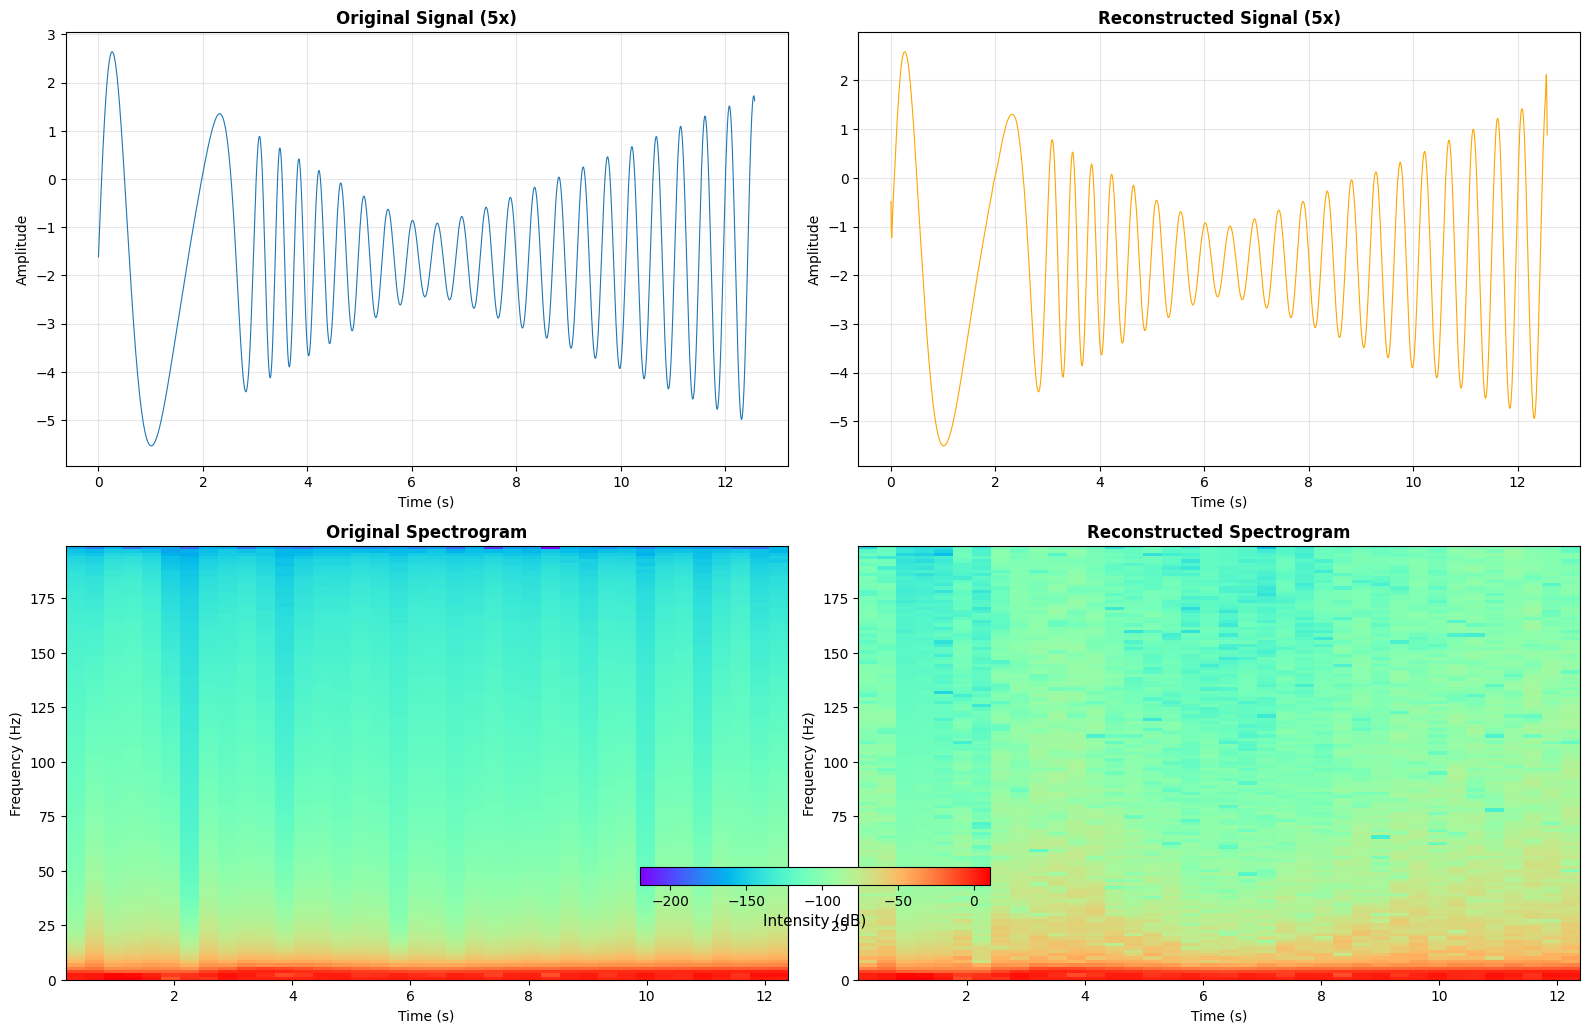


🖼️  Creating spectrogram for 10x...
   💾 Saved: results_spectral/spectrograms/spectrogram_10x.png
   💾 Saved: results_spectral/spectrograms/spectrogram_10x.png


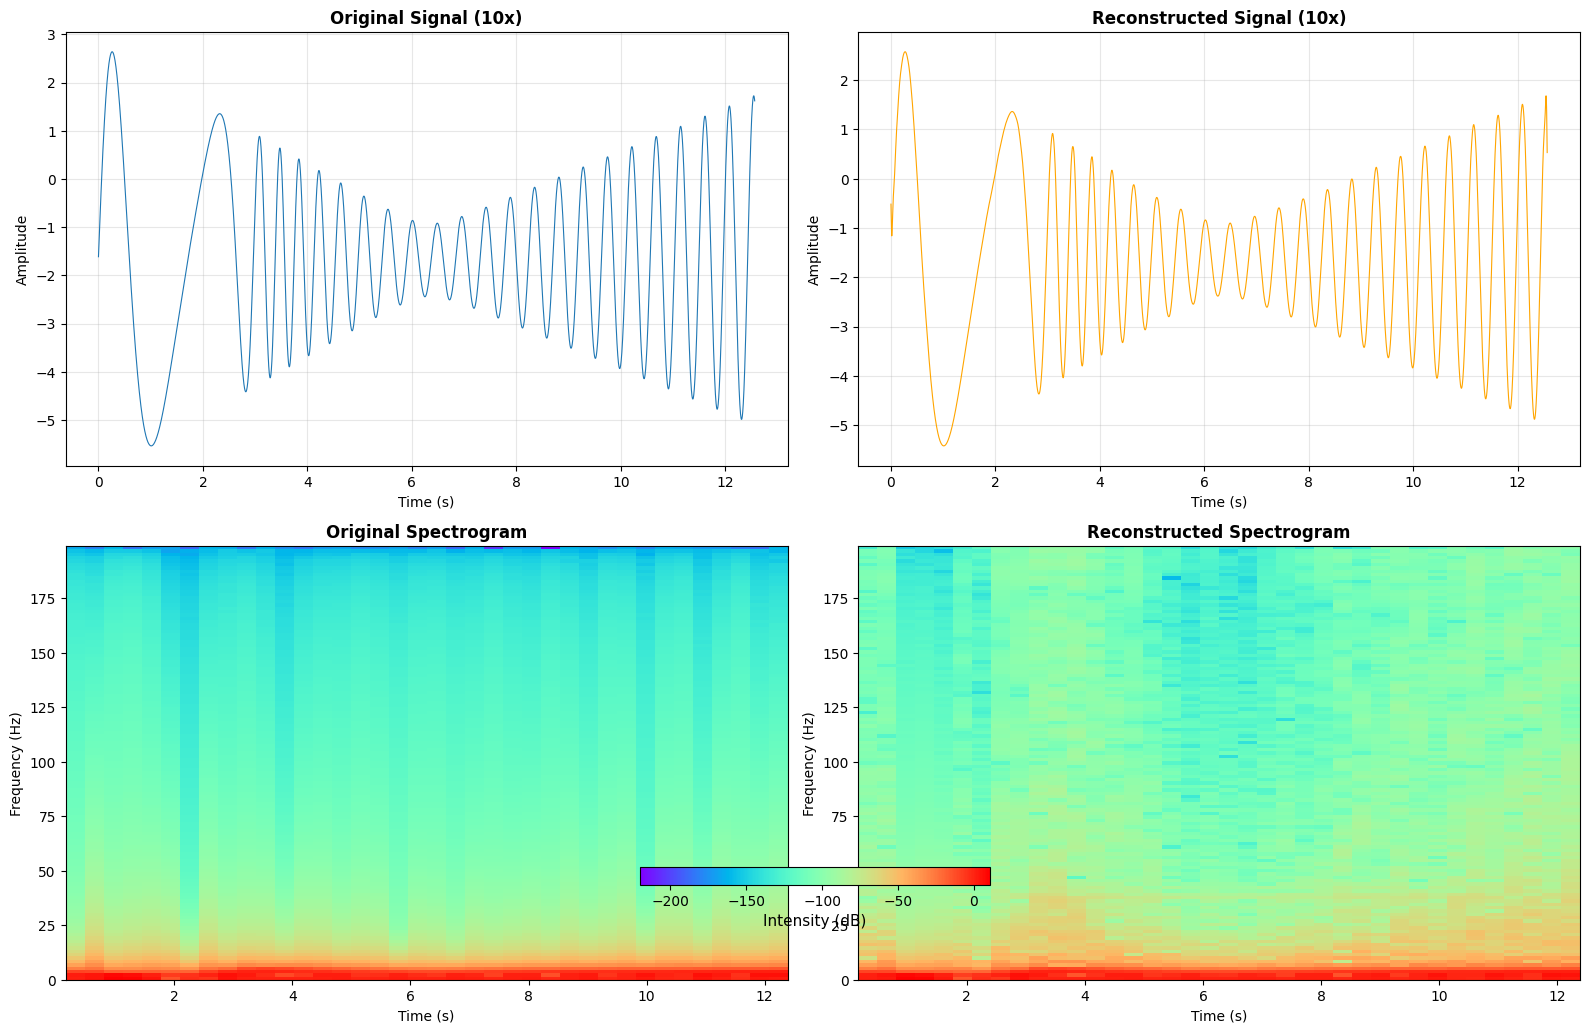


🖼️  Creating spectrogram for 20x...
   💾 Saved: results_spectral/spectrograms/spectrogram_20x.png
   💾 Saved: results_spectral/spectrograms/spectrogram_20x.png


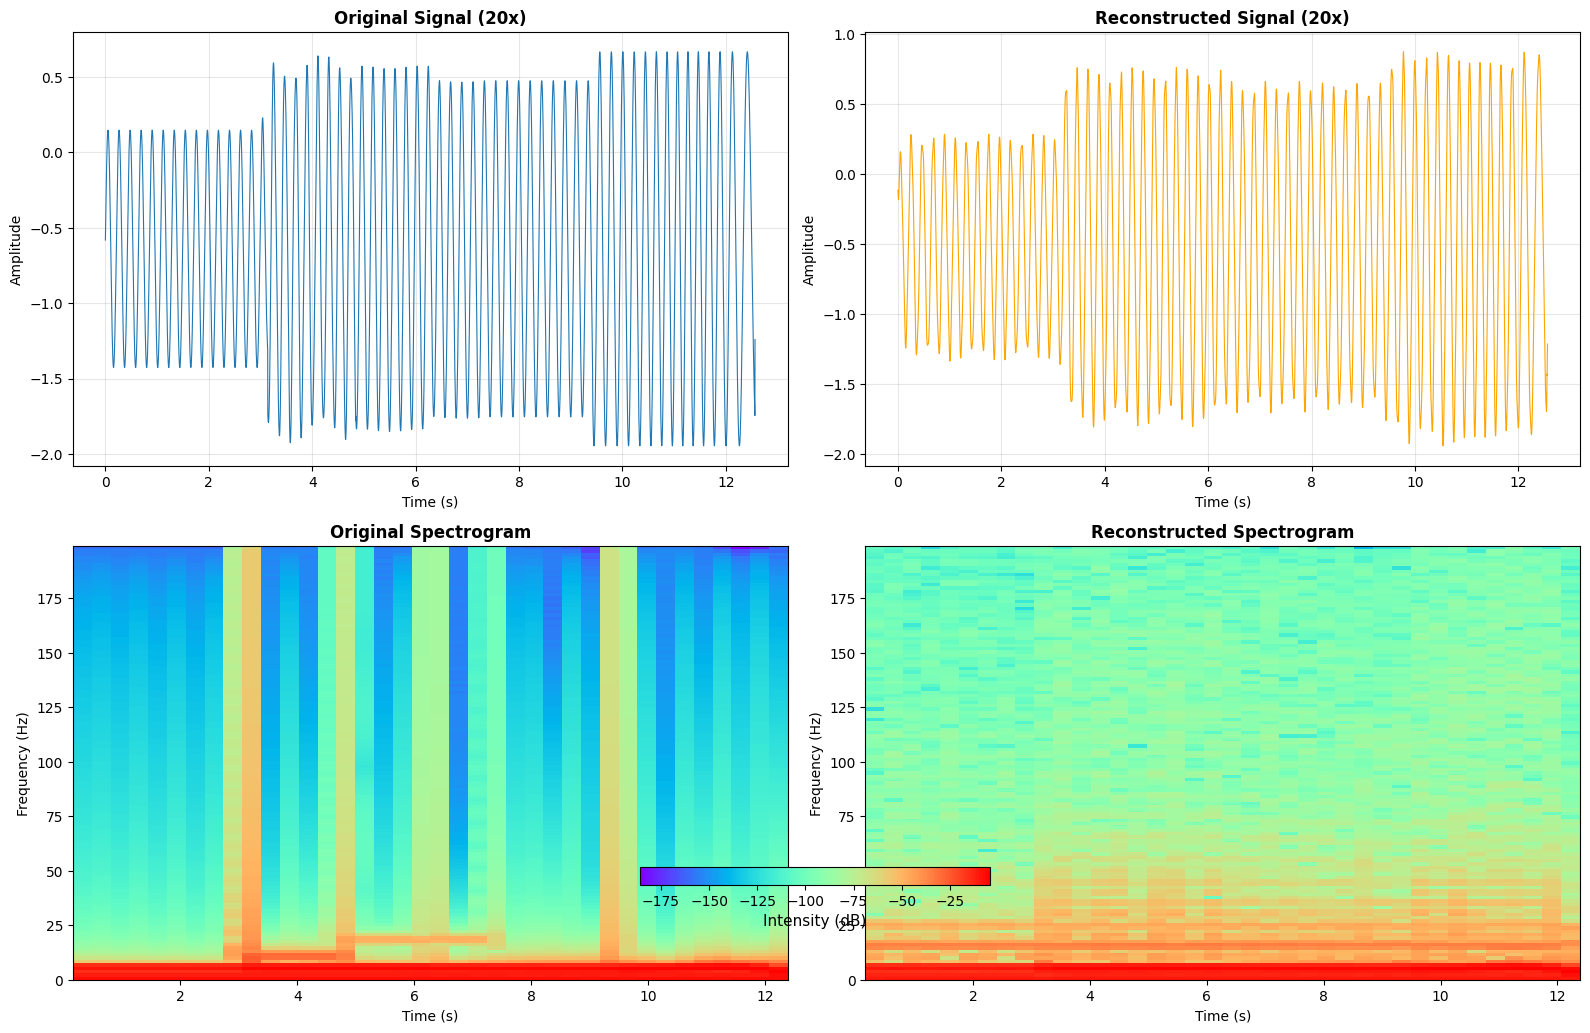


🖼️  Creating spectrogram for 33x...
   💾 Saved: results_spectral/spectrograms/spectrogram_33x.png
   💾 Saved: results_spectral/spectrograms/spectrogram_33x.png


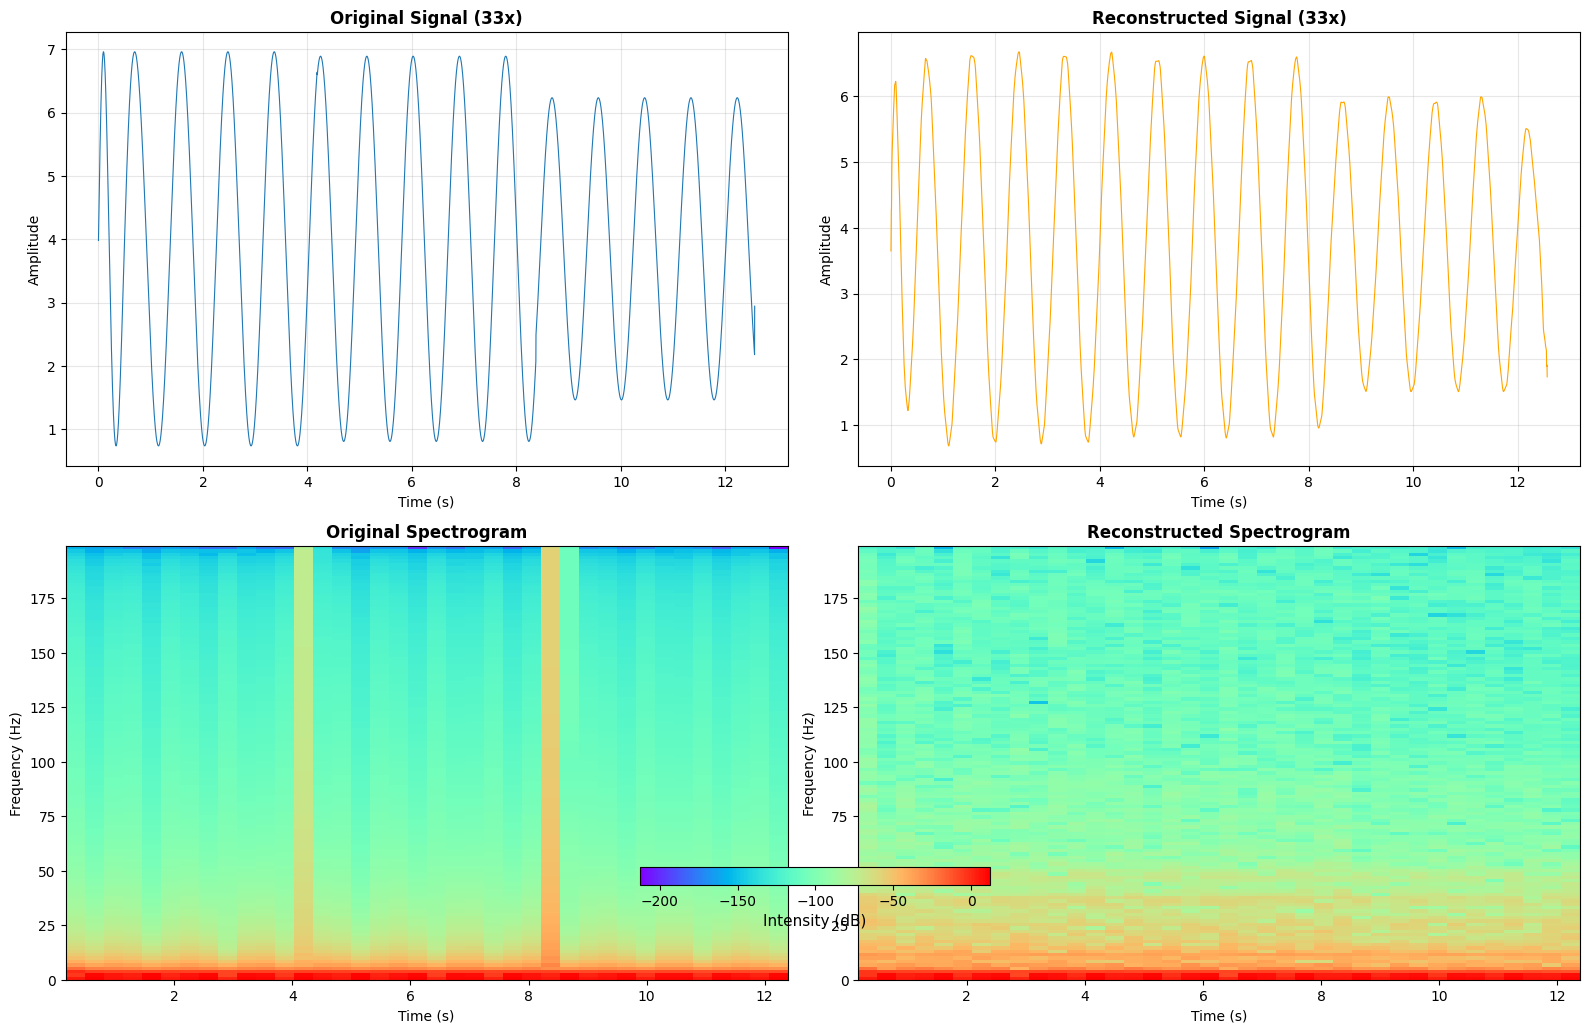


✅ Individual spectrograms generated


In [12]:
print("\n" + "="*60)
print("🎨 GENERATING INDIVIDUAL SPECTROGRAMS")
print("="*60)

# Select one representative signal per factor (e.g., median LSD)
for factor in UPSAMPLE_FACTORS:
    if factor not in predictions:
        continue
    
    print(f"\n🖼️  Creating spectrogram for {factor}x...")
    
    # Find signal with median LSD
    factor_metrics = [m for m in all_metrics if m['factor'] == f"{factor}x"]
    lsd_vals = [m['lsd'] for m in factor_metrics]
    median_idx = np.argsort(lsd_vals)[len(lsd_vals)//2]
    
    # Get signals
    original = validation_data[factor]['high'][median_idx]
    reconstructed = predictions[factor][median_idx]
    
    # Plot
    save_path = RESULTS_DIR / "spectrograms" / f"spectrogram_{factor}x.png"
    plot_single_spectrogram_comparison(
        original, reconstructed, 
        SAMPLING_RATE, 
        factor,
        save_path=save_path,
        NFFT=NFFT,
        noverlap=NOVERLAP
    )

print("\n✅ Individual spectrograms generated")

## 🎭 11. Generate Multi-Factor Grid

Create comprehensive 4x3 comparison grid.


🎭 GENERATING MULTI-FACTOR GRID
💾 Multi-factor grid saved: results_spectral/figures/multifactor_spectrograms_grid.png
💾 Multi-factor grid saved: results_spectral/figures/multifactor_spectrograms_grid.png


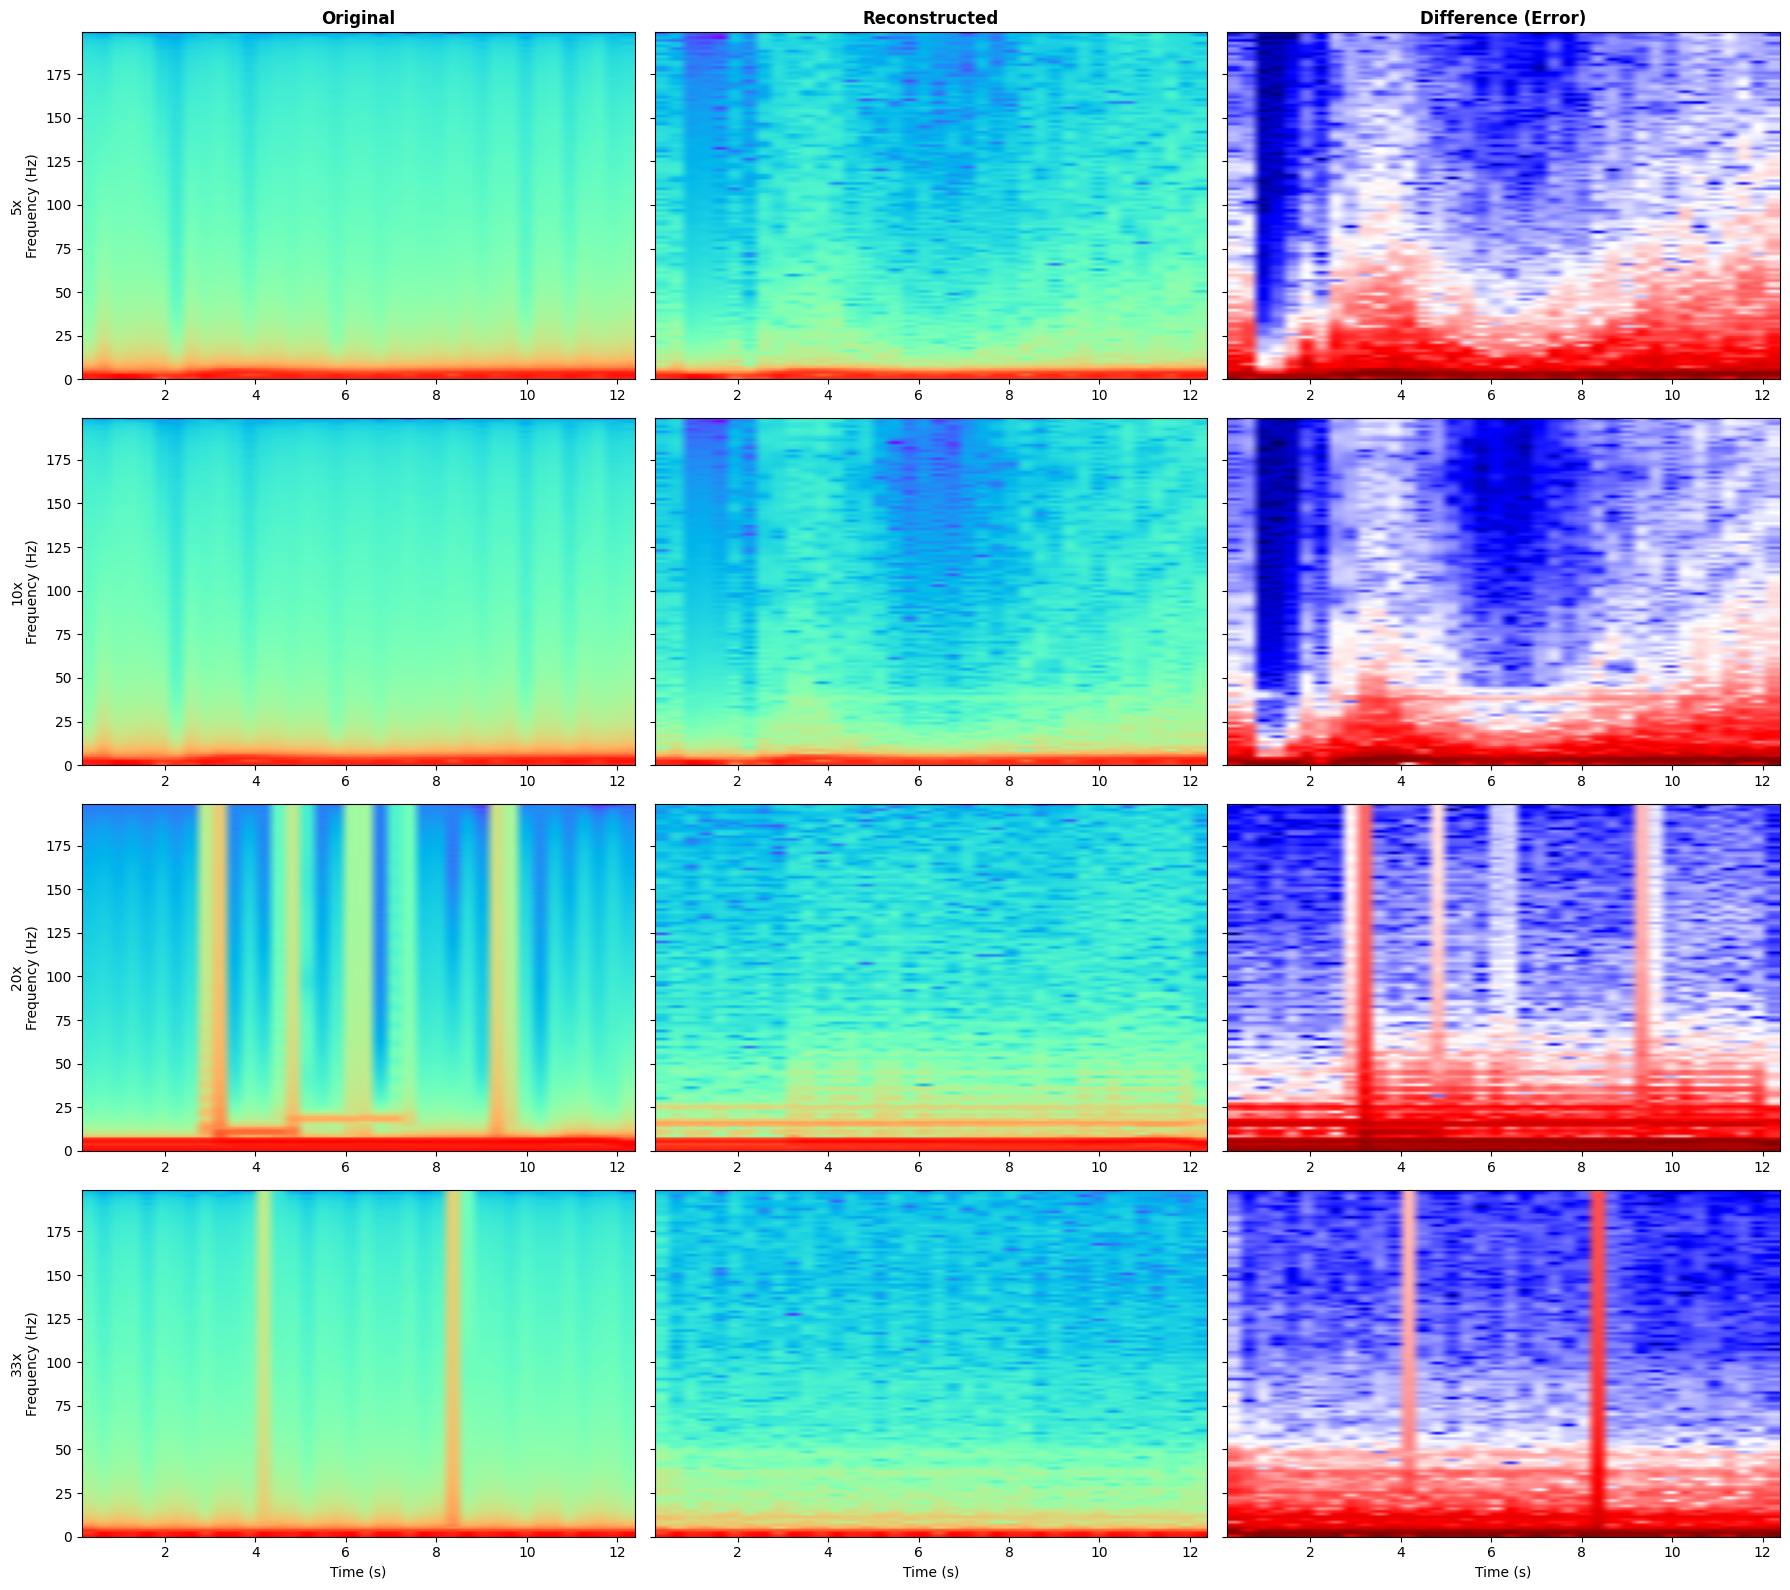


✅ Multi-factor grid generated


In [13]:
print("\n" + "="*60)
print("🎭 GENERATING MULTI-FACTOR GRID")
print("="*60)

# Prepare signals dict for grid
signals_for_grid = {}

for factor in UPSAMPLE_FACTORS:
    if factor not in predictions:
        continue
    
    # Use same median-LSD signal as before
    factor_metrics = [m for m in all_metrics if m['factor'] == f"{factor}x"]
    lsd_vals = [m['lsd'] for m in factor_metrics]
    median_idx = np.argsort(lsd_vals)[len(lsd_vals)//2]
    
    original = validation_data[factor]['high'][median_idx]
    reconstructed = predictions[factor][median_idx]
    
    signals_for_grid[f"{factor}x"] = (original, reconstructed)

# Generate grid
grid_path = RESULTS_DIR / "figures" / "multifactor_spectrograms_grid.png"
plot_multifactor_grid(
    signals_for_grid,
    SAMPLING_RATE,
    save_path=grid_path,
    NFFT=NFFT,
    noverlap=NOVERLAP
)

print("\n✅ Multi-factor grid generated")

## 📊 12. Generate Summary Plots

Create plots showing metric trends across factors.

💾 Trends plot saved: results_spectral/figures/metric_trends.png


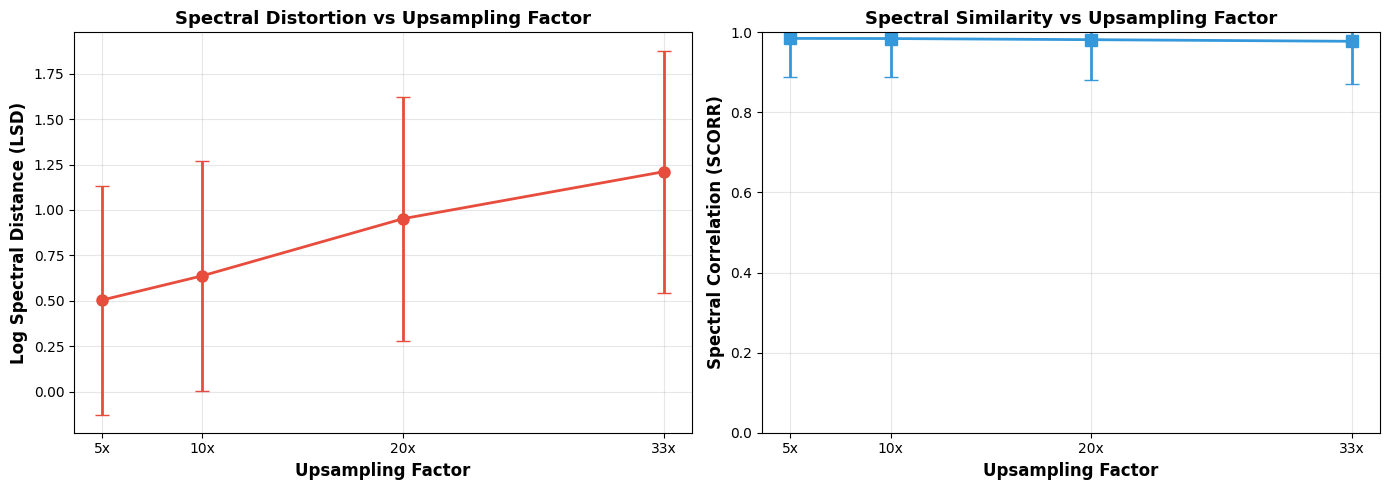

In [14]:
# Extract summary data
factors_list = []
lsd_means = []
lsd_stds = []
scorr_means = []
scorr_stds = []

for factor in UPSAMPLE_FACTORS:
    factor_name = f"{factor}x"
    if factor_name in summary_stats:
        factors_list.append(factor)
        lsd_means.append(summary_stats[factor_name]['lsd']['mean'])
        lsd_stds.append(summary_stats[factor_name]['lsd']['std'])
        scorr_means.append(summary_stats[factor_name]['scorr']['mean'])
        scorr_stds.append(summary_stats[factor_name]['scorr']['std'])

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: LSD vs Factor
ax1.errorbar(factors_list, lsd_means, yerr=lsd_stds, 
             marker='o', markersize=8, linewidth=2, capsize=5,
             color='#e74c3c', label='LSD')
ax1.set_xlabel('Upsampling Factor', fontsize=12, fontweight='bold')
ax1.set_ylabel('Log Spectral Distance (LSD)', fontsize=12, fontweight='bold')
ax1.set_title('Spectral Distortion vs Upsampling Factor', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(factors_list)
ax1.set_xticklabels([f"{f}x" for f in factors_list])

# Plot 2: SCORR vs Factor
ax2.errorbar(factors_list, scorr_means, yerr=scorr_stds,
             marker='s', markersize=8, linewidth=2, capsize=5,
             color='#3498db', label='SCORR')
ax2.set_xlabel('Upsampling Factor', fontsize=12, fontweight='bold')
ax2.set_ylabel('Spectral Correlation (SCORR)', fontsize=12, fontweight='bold')
ax2.set_title('Spectral Similarity vs Upsampling Factor', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(factors_list)
ax2.set_xticklabels([f"{f}x" for f in factors_list])
ax2.set_ylim([0, 1])

plt.tight_layout()

# Save figure
trends_path = RESULTS_DIR / "figures" / "metric_trends.png"
plt.savefig(trends_path, dpi=150, bbox_inches='tight')
print(f"💾 Trends plot saved: {trends_path}")

plt.show()

## 📋 13. Create Results Summary Table

Generate formatted table for paper inclusion.

In [15]:
# Create DataFrame for nice display
df_summary = pd.DataFrame({
    'Factor': [f"{f}x" for f in factors_list],
    'Input Size': [OUTPUT_SIZE // f for f in factors_list],
    'LSD (mean±std)': [f"{m:.4f}±{s:.4f}" for m, s in zip(lsd_means, lsd_stds)],
    'SCORR (mean±std)': [f"{m:.4f}±{s:.4f}" for m, s in zip(scorr_means, scorr_stds)],
    'Signals': [summary_stats[f"{f}x"]['num_signals'] for f in factors_list]
})

print("\n" + "="*60)
print("📋 RESULTS SUMMARY TABLE")
print("="*60)
print(df_summary.to_string(index=False))
print("="*60)

# Save as CSV for LaTeX
table_path = RESULTS_DIR / "metrics" / "summary_table.csv"
df_summary.to_csv(table_path, index=False)
print(f"\n💾 Summary table saved: {table_path}")

# Generate LaTeX table
latex_table = df_summary.to_latex(index=False, escape=False, 
                                   caption="Spectral quality metrics for multi-factor super-resolution",
                                   label="tab:spectral_metrics")

latex_path = RESULTS_DIR / "metrics" / "summary_table.tex"
with open(latex_path, 'w') as f:
    f.write(latex_table)

print(f"💾 LaTeX table saved: {latex_path}")


📋 RESULTS SUMMARY TABLE
Factor  Input Size LSD (mean±std) SCORR (mean±std)  Signals
    5x        1000  0.5051±0.6292    0.9848±0.0970      500
   10x         500  0.6384±0.6317    0.9845±0.0960      500
   20x         250  0.9522±0.6700    0.9817±0.1014      500
   33x         151  1.2106±0.6659    0.9776±0.1072      500

💾 Summary table saved: results_spectral/metrics/summary_table.csv
💾 LaTeX table saved: results_spectral/metrics/summary_table.tex
💾 LaTeX table saved: results_spectral/metrics/summary_table.tex


## ✅ 14. Analysis Complete

Summary of all generated outputs.

In [16]:
print("\n" + "="*60)
print("🎉 SPECTRAL ANALYSIS COMPLETE")
print("="*60)

print("\n📁 Generated Files:")
print(f"   ├─ Metrics:")
print(f"   │  ├─ {csv_path.name}")
print(f"   │  ├─ {json_path.name}")
print(f"   │  ├─ {table_path.name}")
print(f"   │  └─ {latex_path.name}")
print(f"   ├─ Spectrograms:")
for factor in UPSAMPLE_FACTORS:
    spec_file = RESULTS_DIR / "spectrograms" / f"spectrogram_{factor}x.png"
    if spec_file.exists():
        print(f"   │  ├─ {spec_file.name}")
print(f"   └─ Figures:")
print(f"      ├─ {grid_path.name}")
print(f"      └─ {trends_path.name}")

print("\n📊 Key Results:")
for factor in factors_list:
    stats = summary_stats[f"{factor}x"]
    print(f"   {factor}x upsampling:")
    print(f"      LSD:   {stats['lsd']['mean']:.4f} (lower is better)")
    print(f"      SCORR: {stats['scorr']['mean']:.4f} (higher is better)")

print("\n💡 Next Steps:")
print("   1. Review spectrograms in ./results_spectral/spectrograms/")
print("   2. Check metrics CSV for per-signal analysis")
print("   3. Use LaTeX table for paper inclusion")
print("   4. Analyze trends plot for factor-dependent degradation")

print("\n" + "="*60)


🎉 SPECTRAL ANALYSIS COMPLETE

📁 Generated Files:
   ├─ Metrics:
   │  ├─ spectral_metrics_per_signal.csv
   │  ├─ spectral_metrics_summary.json
   │  ├─ summary_table.csv
   │  └─ summary_table.tex
   ├─ Spectrograms:
   │  ├─ spectrogram_5x.png
   │  ├─ spectrogram_10x.png
   │  ├─ spectrogram_20x.png
   │  ├─ spectrogram_33x.png
   └─ Figures:
      ├─ multifactor_spectrograms_grid.png
      └─ metric_trends.png

📊 Key Results:
   5x upsampling:
      LSD:   0.5051 (lower is better)
      SCORR: 0.9848 (higher is better)
   10x upsampling:
      LSD:   0.6384 (lower is better)
      SCORR: 0.9845 (higher is better)
   20x upsampling:
      LSD:   0.9522 (lower is better)
      SCORR: 0.9817 (higher is better)
   33x upsampling:
      LSD:   1.2106 (lower is better)
      SCORR: 0.9776 (higher is better)

💡 Next Steps:
   1. Review spectrograms in ./results_spectral/spectrograms/
   2. Check metrics CSV for per-signal analysis
   3. Use LaTeX table for paper inclusion
   4. Analyze t